In [1]:
# Setup
import importlib
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
from sccoda.util import cell_composition_data as dat
from sccoda.util import data_visualization as viz

import sccoda.datasets as scd

from sccoda.model.scCODA_model import EricaModel

2025-10-03 14:12:45.838333: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-03 14:12:45.838727: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-03 14:12:45.901537: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-03 14:12:49.997899: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

### Loading Data

In [2]:
# Read data into pandas from csv

cell_counts = scd.haber()

print(cell_counts)

            Mouse  Endocrine  Enterocyte  Enterocyte.Progenitor  Goblet  Stem  \
0       Control_1         36          59                    136      36   239   
1       Control_2          5          46                     23      20    50   
2       Control_3         45          98                    188     124   250   
3       Control_4         26         221                    198      36   131   
4  H.poly.Day10_1         42          71                    203     147   271   
5  H.poly.Day10_2         40          57                    383     170   321   
6   H.poly.Day3_1         52          75                    347      66   323   
7   H.poly.Day3_2         65         126                    115      33    65   
8          Salm_1         37         332                    113      59    90   
9          Salm_2         32         373                    116      67   117   

    TA  TA.Early  Tuft  
0  125       191    18  
1   11        40     5  
2  155       365    33  
3  130  

### Converting data to anndata object

In [15]:
# Convert data to anndata object
data_all = dat.from_pandas(cell_counts, covariate_columns=["Mouse"])

# Extract condition from mouse name and add it as an extra column to the covariates
data_all.obs["Condition"] = data_all.obs["Mouse"].str.replace(r"_[0-9]", "", regex=True)
print(data_all)

AnnData object with n_obs × n_vars = 10 × 8
    obs: 'Mouse', 'Condition'


In [16]:

# Select control and salmonella data
data_salm = data_all[data_all.obs["Condition"].isin(["Control", "Salm"])]
print(data_salm.obs)


       Mouse Condition
0  Control_1   Control
1  Control_2   Control
2  Control_3   Control
3  Control_4   Control
8     Salm_1      Salm
9     Salm_2      Salm


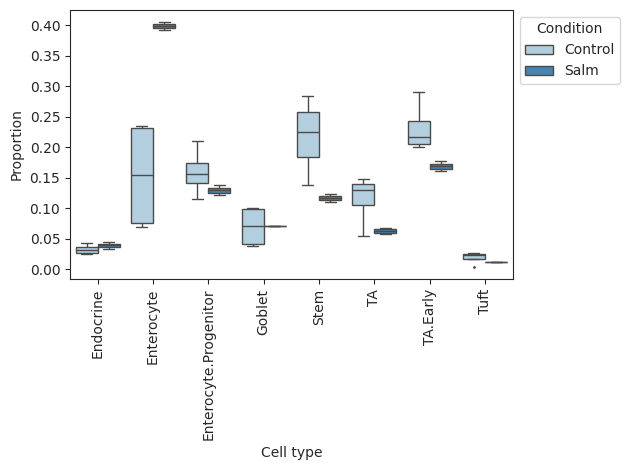

In [17]:
viz.boxplots(data_salm, feature_name="Condition")
plt.show()

### Building Design Matrix for Covariate

In [6]:
import patsy as pt

covariate_matrix_full = pt.dmatrix("Condition", data_salm.obs)
covariate_matrix=covariate_matrix_full[:,1:]
covariate_names = ["Condition"]  

In [7]:
import numpy as np

cell_types = list(data_salm.var.index)
ref_idx = cell_types.index("Goblet")

model_salm = EricaModel(
    reference_cell_type=ref_idx,
    data_matrix=data_salm.X.astype("float64"),
    covariate_matrix=np.array(covariate_matrix),
    cell_types=cell_types,
    covariate_names=covariate_names,
    formula="Condition"
)


2025-10-03 13:40:23.310524: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


We first run the default parameters as a baseline.

In [8]:
# Run HMC sampling
sim_results = model_salm.sample_hmc(
    num_results=5000,  
    num_burnin=1000,
    step_size=0.01,
    num_leapfrog_steps=10
)

# Summary
print(sim_results.summary())


2025-10-03 13:40:31.551426: I external/local_xla/xla/service/service.cc:163] XLA service 0x7fbcc4007300 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-10-03 13:40:31.551446: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): Host, Default Version
  0%|                                                                                                                                                  | 0/5000 [00:00<?, ?it/s]2025-10-03 13:40:31.725473: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1759513232.802932 3434490 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:16<00:00

MCMC sampling finished. (21.917 sec)
Acceptance rate: 60.5%
Compositional Analysis summary:

Data: 6 samples, 8 cell types
Reference index: 3
Formula: Condition

Intercepts:
                       Final Parameter  Expected Sample
Cell Type                                              
Endocrine                        1.142        34.992750
Enterocyte                       2.340       115.947895
Enterocyte.Progenitor            2.539       141.477530
Goblet                           1.768        65.440472
Stem                             2.717       169.040935
TA                               2.129        93.891598
TA.Early                         2.870       196.987624
Tuft                             0.433        17.221195


Effects:
                                 Final Parameter  Expected Sample  \
Covariate Cell Type                                                 
Condition Endocrine                     0.000000        25.024253   
          Enterocyte                    1.352931

We now run EricaModel 6 different times, changing one default parameter for each run. First, we begin by changing the mean of the alpha random variable (the intercept for the GLM) to 1.0. We then change the standard deviation of the alpha random variable to 2.0. We then change the sigma parameter (which controls the magnitude of the raw effect) to 0.5. We also alter the gamma random variable (drawn from Normal distribution which controls sign and magnitude of the raw effect). First, we change the mean from 0.0 to 0 and then the standard deviation from 1.0 to 0.5. Finaly, we change the log-odds scale from 50.0 to 25. 

In [ ]:
default_priors = {
    "alpha_loc": 0.0,
    "alpha_sd": 5.0,
    "sigma_hc_scale": 1.0,
    "gamma_loc": 0.0,
    "gamma_sd": 1.0,
    "tau_temperature": 50.0
}

# Each dict changes only one prior from the default
priors_list = [
    {**default_priors, "alpha_loc": 0.5},
    {**default_priors, "alpha_loc": 10.0},          
    {**default_priors, "alpha_sd": 0.5},
    {**default_priors, "alpha_sd": 10.0},            
    {**default_priors, "sigma_hc_scale": 0.25},   
    {**default_priors, "sigma_hc_scale": 5.0},   
    {**default_priors, "gamma_loc": 0.25}, 
    {**default_priors, "gamma_loc": 5.0},          
    {**default_priors, "gamma_sd": 0.25},
    {**default_priors, "gamma_sd": 5.0},             
    {**default_priors, "tau_temperature": 1.0},
    {**default_priors, "tau_temperature": 100.0}
]

results = []

for i, priors in enumerate(priors_list, 1):
    print(f"\n=== Running model with prior {i}/{len(priors_list)} ===\n")
    
    cell_types = list(data_salm.var.index)
    ref_idx = cell_types.index("Goblet")

    model = EricaModel(
        reference_cell_type=ref_idx,
        data_matrix=data_salm.X.astype("float64"),
        covariate_matrix=covariate_matrix,
        cell_types=cell_types,
        covariate_names=covariate_names,
        formula="Condition",
        **priors  
    )
    
    # Run HMC sampling
    sample_result = model.sample_hmc(num_results=5000, num_burnin=1000)
    results.append(sample_result)
    
    # Print summary of the last run
    print(sample_result.summary())


In [1]:
def values(arr):
        mean = arr.mean(axis=(0,1))               
        lo = np.percentile(arr, 2.5, axis=(0,1))  
        hi = np.percentile(arr, 97.5, axis=(0,1))  
        return mean, lo, hi

In [2]:
def summarize(data, prior_label, reference=0):
    "Extract summaries from inference data object"
    
    pred = data.posterior_predictive["prediction"].values
    cell_types = list(data.posterior_predictive.cell_type.values)
    reference_name = cell_types[reference]
    
    # Overall expected samples
    pred_mean, pred_lo, pred_hi = values(pred)            
    pred_mean = pred_mean.mean(axis=0)                   
    pred_lo   = pred_lo.mean(axis=0)
    pred_hi   = pred_hi.mean(axis=0)
    
     # intercept expected sample
    alpha = data.posterior["alpha"].values  
    alpha_mean, alpha_lo, alpha_hi = values(alpha)  
    
     # effect expected sample
    beta = data.posterior["beta"].values[..., 0, :]
    beta_mean, beta_lo, beta_hi = values(beta)
    
    #log fold change
    ref_pred = pred[..., reference:reference+1]
    logfc = np.log2(pred / ref_pred)                    
    logfc_mean, logfc_lo, logfc_hi = values(logfc)       
    logfc_mean = logfc_mean.mean(axis=0)           
    logfc_lo   = logfc_lo.mean(axis=0)
    logfc_hi   = logfc_hi.mean(axis=0)
    
    rows = []
    for i, ct in enumerate(cell_types):
        rows.append({
            "cell_type": ct, "reference": reference_name, "prior": prior_label,
            "metric": "expected_sample",
            "mean": pred_mean[i], "lo": pred_lo[i], "hi": pred_hi[i]
        })
        rows.append({
            "cell_type": ct, "reference": reference_name, "prior": prior_label,
            "metric": "intercept_expected_sample",
            "mean": alpha_mean[i], "lo": alpha_lo[i], "hi": alpha_hi[i]
        })
        rows.append({
            "cell_type": ct, "reference": reference_name, "prior": prior_label,
            "metric": "effect_expected_sample",
            "mean": beta_mean[i], "lo": beta_lo[i], "hi": beta_hi[i]
        })
        rows.append({
            "cell_type": ct, "reference": reference_name, "prior": prior_label,
            "metric": "log2FC",
            "mean": logfc_mean[i], "lo": logfc_lo[i], "hi": logfc_hi[i]
        })

    return pd.DataFrame(rows)

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_grid(df, param_name=None):
    metrics = ["expected_sample", "log2FC", "effect_expected_sample", "intercept_expected_sample"]
    titles  = ["Expected Samples", "Log2 Fold Change", "Effect Expected Sample", "Intercept Expected Sample"]

    n_metrics = len(metrics)
    cell_types = df["cell_type"].unique()
    n_cells = len(cell_types)

    prior_order = ["low", "default", "high"]

    palette = {
        "expected_sample": "#4C72B0",         
        "log2FC": "#55A868",                   
        "effect_expected_sample": "#C44E52",   
        "intercept_expected_sample": "#8172B2" 
    }

    fig, axes = plt.subplots(n_cells, n_metrics, figsize=(4*n_metrics, 3*n_cells), sharex=False)

    if n_cells == 1:
        axes = axes[np.newaxis, :]  

    for i, ct in enumerate(cell_types):
        for j, metric in enumerate(metrics):
            ax = axes[i, j]
            sub = df[(df["cell_type"] == ct) & (df["metric"] == metric)].copy()

            # sort priors
            sub["prior"] = pd.Categorical(sub["prior"], categories=prior_order, ordered=True)
            sub = sub.sort_values("prior")

            color = palette[metric]

            if metric == "expected_sample":
                ax.bar(sub["prior"], sub["mean"], color=color, alpha=0.8)
            else:
                ax.plot(sub["prior"], sub["mean"], marker="o", color=color, linewidth=2)
                ax.fill_between(
                    sub["prior"], sub["lo"], sub["hi"],
                    color=color, alpha=0.2
                )

            ax.set_xticks(range(len(prior_order)))
            ax.set_xticklabels(prior_order, rotation=45, ha="right", fontsize=9)
            ax.tick_params(axis="y", labelsize=8)
            ax.grid(True, linestyle="--", alpha=0.4)

            if i == 0:
                ax.set_title(titles[j], fontsize=11, fontweight="bold")
            if j == 0:
                ax.set_ylabel(ct, fontsize=9, fontweight="bold")
            else:
                ax.set_ylabel("")

    if param_name is not None:
        fig.suptitle(f"{param_name}", fontsize=14, fontweight="bold", y=1.02)
        
    plt.tight_layout()
    return fig, axes

In [ ]:
# parameter alpha_loc
df_default = summarize(sim_results, prior_label="default", reference=ref_idx)
df_low = summarize(results[0], prior_label="low", reference=ref_idx)
df_high = summarize(results[1], prior_label="high", reference=ref_idx)
df_all = pd.concat([df_default, df_low, df_high], ignore_index=True)

plot_grid(df_all, param_name="alpha_loc")
plt.show()

In [ ]:
# parameter alpha_sd
df_default = summarize(sim_results, prior_label="default", reference=ref_idx)
df_low = summarize(results[2], prior_label="low", reference=ref_idx)
df_high = summarize(results[3], prior_label="high", reference=ref_idx)
df_all = pd.concat([df_default, df_low, df_high], ignore_index=True)
plot_grid(df_all, param_name="alpha_sd")
plt.show()

In [ ]:
# paramter sigma_hc_scale
df_default = summarize(sim_results, prior_label="default", reference=ref_idx)
df_low = summarize(results[4], prior_label="low", reference=ref_idx)
df_high = summarize(results[5], prior_label="high", reference=ref_idx)
df_all = pd.concat([df_default, df_low, df_high], ignore_index=True)
plot_grid(df_all, param_name="sigma_hc_scale")
plt.show()

In [ ]:
# parameter gamma_loc
df_default = summarize(sim_results, prior_label="default", reference=ref_idx)
df_low = summarize(results[6], prior_label="low", reference=ref_idx)
df_high = summarize(results[7], prior_label="high", reference=ref_idx)
df_all = pd.concat([df_default, df_low, df_high], ignore_index=True)
plot_grid(df_all, param_name="gamma_loc")
plt.show()

In [ ]:
# parameter gamma_sd
df_default = summarize(sim_results, prior_label="default", reference=ref_idx)
df_low = summarize(results[8], prior_label="low", reference=ref_idx)
df_high = summarize(results[9], prior_label="high", reference=ref_idx)
df_all = pd.concat([df_default, df_low, df_high], ignore_index=True)
plot_grid(df_all, param_name="gamma_sd")
plt.show()

In [ ]:
# parameter tau_temperature
df_default = summarize(sim_results, prior_label="default", reference=ref_idx)
df_low = summarize(results[10], prior_label="low", reference=ref_idx)
df_high = summarize(results[11], prior_label="high", reference=ref_idx)
df_all = pd.concat([df_default, df_low, df_high], ignore_index=True)
plot_grid(df_all, param_name="tau_temperature")
plt.show()


In [ ]:
data = pd.read_csv("/users/ebrown62/scCODA/sccoda/datasets/scCODA_aging_atlas.csv")
data = data.set_index("donor_id")
data.head()


data_all = dat.from_pandas(data, covariate_columns=["sex", "tissue"])
print(data_all)

In [ ]:

viz.boxplots(data_all, feature_name="sex")
plt.show()


In [ ]:
import patsy as pt


covariate_matrix_full = pt.dmatrix("~ C(sex) + C(tissue)", data_all.obs)
covariate_matrix=covariate_matrix_full[:,1:]
covariate_names = covariate_matrix_full.design_info.column_names[1:]

In [ ]:
# reference selection from sccoda util
import numpy as np
cell_types = list(data_all.var.index)


automatic_reference_absence_threshold = 0.05
percent_zero = np.sum(data_all.X == 0, axis=0)/data_all.X.shape[0]
nonrare_ct = np.where(percent_zero < automatic_reference_absence_threshold)[0]
rel_abun = data_all.X / np.sum(data_all.X, axis=1, keepdims=True)
# select reference
cell_type_disp = np.var(rel_abun, axis=0)/np.mean(rel_abun, axis=0)
min_var = np.min(cell_type_disp[nonrare_ct])
ref_index = np.where(cell_type_disp == min_var)[0][0]


ref_cell_type = cell_types[ref_index]
print(f"Automatic reference selection! Reference cell type set to {ref_cell_type}")


In [ ]:

cell_types = list(data_all.var.index)


basic_model = EricaModel(
   reference_cell_type=ref_index,
   data_matrix=data_all.X.astype("float64"),
   covariate_matrix=covariate_matrix,
   cell_types=cell_types,
   covariate_names=covariate_names,
   formula="~ sex + tissue"
)
# Run HMC sampling
aging_results_basic = basic_model.sample_hmc(
   num_results=5000, 
   num_burnin=1000,
   step_size=0.01,
   num_leapfrog_steps=20
)


# Summary
print(aging_results_basic.summary())

In [ ]:
default_priors = {
   "alpha_loc": 0.0,
   "alpha_sd": 5.0,
   "sigma_hc_scale": 1.0,
   "gamma_loc": 0.0,
   "gamma_sd": 1.0,
   "tau_temperature": 50.0
}


# Each dict changes only one prior from the default
priors_list = [
   {**default_priors, "alpha_loc": 0.5},
   {**default_priors, "alpha_loc": 10.0},         
   {**default_priors, "alpha_sd": 0.5},
   {**default_priors, "alpha_sd": 10.0},           
   {**default_priors, "sigma_hc_scale": 0.25},  
   {**default_priors, "sigma_hc_scale": 5.0},  
   {**default_priors, "gamma_loc": 0.25},
   {**default_priors, "gamma_loc": 5.0},         
   {**default_priors, "gamma_sd": 0.25},
   {**default_priors, "gamma_sd": 5.0},            
   {**default_priors, "tau_temperature": 1.0},
   {**default_priors, "tau_temperature": 100.0}
]


sensitivity_results = []


for i, priors in enumerate(priors_list, 1):
   print(f"\n=== Running model with prior {i}/{len(priors_list)} ===\n")
   cell_types = list(data_all.var.index)


   sensitivity_model = EricaModel(
       reference_cell_type=ref_index,
       data_matrix=data_all.X.astype("float64"),
       covariate_matrix=covariate_matrix,
       cell_types=cell_types,
       covariate_names=covariate_names,
       formula="~ sex + tissue",
       **priors 
   )
  
   # Run HMC sampling
   sensitivity_result = sensitivity_model.sample_hmc(num_results=5000, 
   num_burnin=1000,
   step_size=0.01,
   num_leapfrog_steps=20)
   sensitivity_results.append(sensitivity_result)
  
   # Print summary of the last run
   print(sensitivity_result.summary())

In [ ]:
# parameter alpha_loc
df_default = summarize(aging_results_basic, prior_label="default", reference=ref_index)
df_low = summarize(sensitivity_results[0], prior_label="low", reference=ref_index)
df_high = summarize(sensitivity_results[1], prior_label="high", reference=ref_index)
df_all = pd.concat([df_default, df_low, df_high], ignore_index=True)


plot_grid(df_all, param_name="alpha_loc")
plt.show()

In [ ]:
# parameter alpha_sd
df_default = summarize(aging_results_basic, prior_label="default", reference=ref_index)
df_low = summarize(sensitivity_results[2], prior_label="low", reference=ref_index)
df_high = summarize(sensitivity_results[3], prior_label="high", reference=ref_index)
df_all = pd.concat([df_default, df_low, df_high], ignore_index=True)
plot_grid(df_all, param_name="alpha_sd")
plt.show()

In [ ]:
# paramter sigma_hc_scale
df_default = summarize(aging_results_basic, prior_label="default", reference=ref_index)
df_low = summarize(sensitivity_results[4], prior_label="low", reference=ref_index)
df_high = summarize(sensitivity_results[5], prior_label="high", reference=ref_index)
df_all = pd.concat([df_default, df_low, df_high], ignore_index=True)
plot_grid(df_all, param_name="sigma_hc_scale")
plt.show()

In [ ]:
# paramter gamma_loc
df_default = summarize(aging_results_basic, prior_label="default", reference=ref_index)
df_low = summarize(sensitivity_results[6], prior_label="low", reference=ref_index)
df_high = summarize(sensitivity_results[7], prior_label="high", reference=ref_index)
df_all = pd.concat([df_default, df_low, df_high], ignore_index=True)
plot_grid(df_all, param_name="gamma_loc")
plt.show()

In [ ]:
# paramter gamma_sd
df_default = summarize(aging_results_basic, prior_label="default", reference=ref_index)
df_low = summarize(sensitivity_results[8], prior_label="low", reference=ref_index)
df_high = summarize(sensitivity_results[9], prior_label="high", reference=ref_index)
df_all = pd.concat([df_default, df_low, df_high], ignore_index=True)
plot_grid(df_all, param_name="gamma_sd")
plt.show()

In [ ]:
# parameter tau_temperature
df_default = summarize(aging_results_basic, prior_label="default", reference=ref_index)
df_low = summarize(sensitivity_results[10], prior_label="low", reference=ref_index)
df_high = summarize(sensitivity_results[11], prior_label="high", reference=ref_index)
df_all = pd.concat([df_default, df_low, df_high], ignore_index=True)
plot_grid(df_all, param_name="tau_temperature")
plt.show()